# 1. Introduction:
This report examines the impact of macroeconomic policy announcements on the volatility of the USD/CAD exchange rate, a crucial factor in international trade and finance.

Understanding this relationship is vital for businesses and investors who need to manage exchange rate risk. Policy announcements, such as interest rate changes, can significantly influence market expectations and lead to increased volatility.

By applying time series analysis techniques, this study aims to identify significant policy events that correlate with volatility spikes and to develop models that can filter out noise and reveal underlying trends.

The analysis will employ methods including convolution, spectral analysis, and filtering to explore the dynamics of the USD/CAD exchange rate.

In [4]:
import requests
import pandas as pd

# Define the API endpoint and parameters
url = 'https://www.bankofcanada.ca/valet/observations/FXUSDCAD/json'
params = {
    'start_date': '2017-01-01',
    'end_date': '2025-04-09'
}

# Make the API request
response = requests.get(url, params=params)
data = response.json()

# Extract and transform observations
records = []
for obs in data['observations']:
    date = obs['d']
    value = obs['FXUSDCAD'].get('v', None)  # Extract the value, or None if missing
    if value is not None:
        records.append({'date': pd.to_datetime(date), 'FXUSDCAD': float(value)})

# Create a DataFrame
df = pd.DataFrame(records)
df.set_index('date', inplace=True)

# Preview and save
print(df.head())
df.to_csv('USD_CAD_exchange_rates.csv')


            FXUSDCAD
date                
2017-01-03    1.3435
2017-01-04    1.3315
2017-01-05    1.3244
2017-01-06    1.3214
2017-01-09    1.3240


No non-numeric values found.


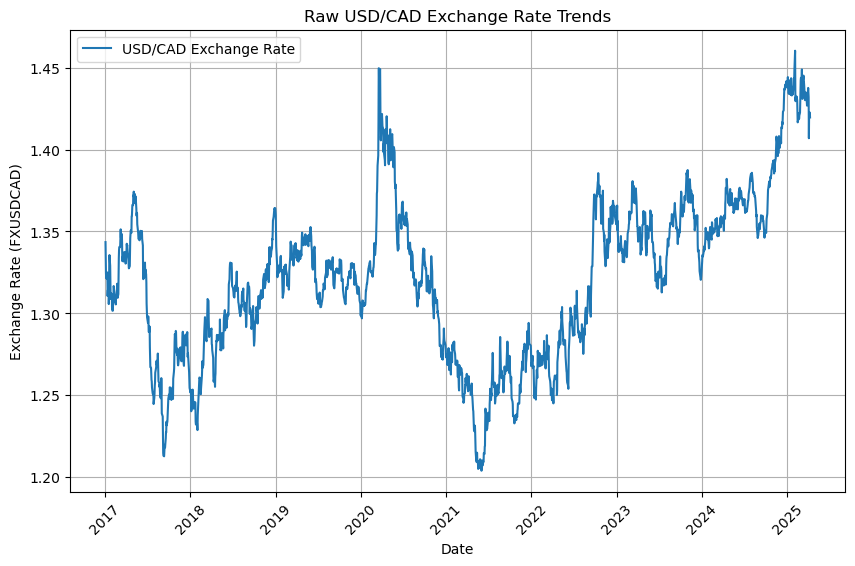

Dataframe after SMA and row removal:
         date  FXUSDCAD       SMA
29 2017-02-13    1.3082  1.316233
30 2017-02-14    1.3070  1.315017
31 2017-02-15    1.3088  1.314260
32 2017-02-16    1.3055  1.313630
33 2017-02-17    1.3102  1.313257
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2034 entries, 29 to 2062
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2034 non-null   datetime64[ns]
 1   FXUSDCAD  2034 non-null   float64       
 2   SMA       2034 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 47.8 KB
None


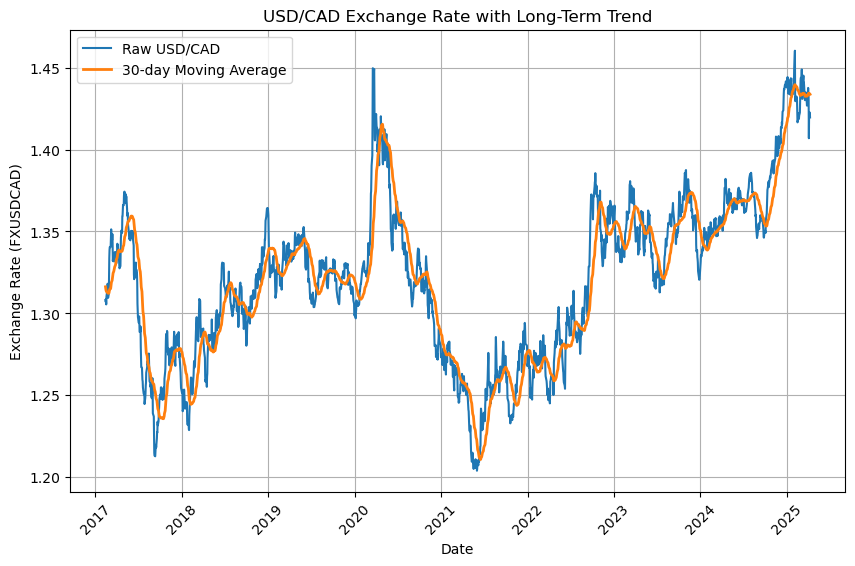

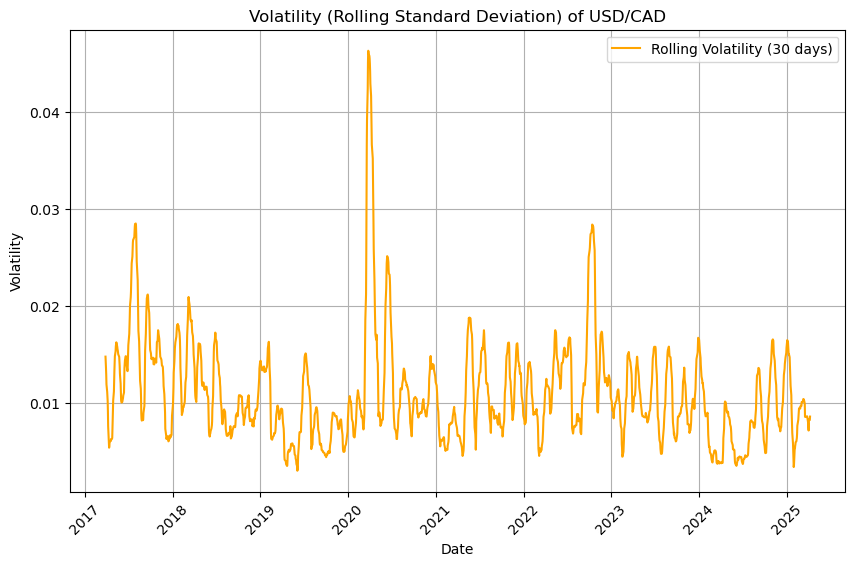

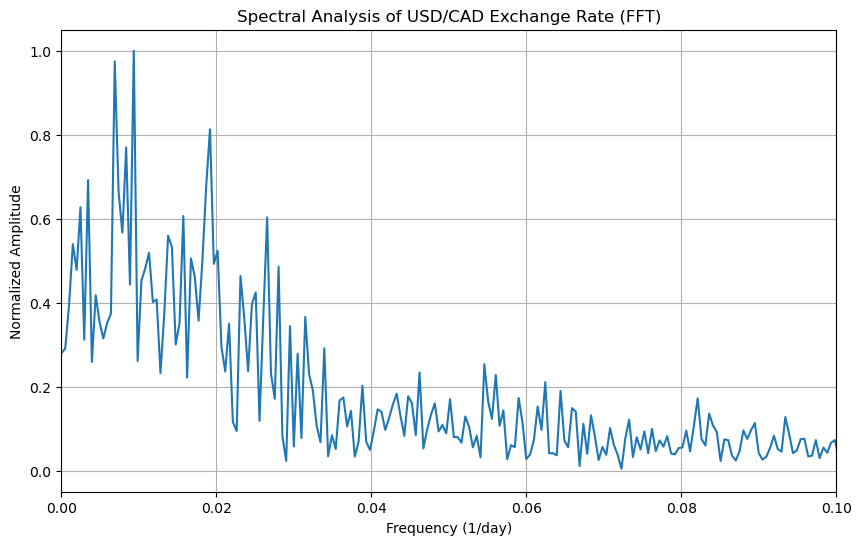

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft

# Load the dataset
data = pd.read_csv("USD_CAD_exchange_rates.csv")

# Step 1: Clean and Process the Data
# Convert the 'date' column to datetime format
# This step ensures that the 'date' column is recognized as datetime objects, allowing for time-based analysis.
data['date'] = pd.to_datetime(data['date'])

# Ensure 'FXUSDCAD' column is numeric and check for non-numeric values
# This step converts the 'FXUSDCAD' column to numeric, handling any non-numeric entries by converting them to NaN (Not a Number).
# It also checks for the existence of non-numeric values that were coerced to NaN.
data['FXUSDCAD'] = pd.to_numeric(data['FXUSDCAD'], errors='coerce')

non_numeric = data['FXUSDCAD'][pd.to_numeric(data['FXUSDCAD'], errors='coerce').isnull()]
if not non_numeric.empty:
    print("Non-numeric values found:")
    print(non_numeric)
else:
    print("No non-numeric values found.")

# Remove rows with NaN values (if any were created by to_numeric)
# This step removes any rows containing NaN values, ensuring clean data for subsequent analysis.
data = data.dropna()

# Step 2: Visualize Raw Exchange Rate Trends
# This step plots the raw USD/CAD exchange rate against time, providing a visual representation of the data's overall trend and fluctuations.
plt.figure(figsize=(10, 6))
plt.plot(data['date'], data['FXUSDCAD'], label="USD/CAD Exchange Rate")
plt.title('Raw USD/CAD Exchange Rate Trends')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (FXUSDCAD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# Step 3: Apply Filtering to Extract Long-Term Trends (Simple Moving Average)
# This step calculates the 30-day Simple Moving Average (SMA), smoothing out short-term fluctuations and highlighting the long-term trend.
window_size = 30  # Define the window size for moving average (e.g., 30 days)
data['SMA'] = data['FXUSDCAD'].rolling(window=window_size).mean()

# Remove the first 29 rows, that were caused by the SMA calculation.
# Due to the rolling window, the first 'window_size - 1' rows will have NaN values. This step removes these rows to maintain data consistency.
data = data.iloc[window_size - 1:]

print("Dataframe after SMA and row removal:")
print(data.head())
print(data.info())

# Plot the long-term trend (SMA)
# This step plots both the raw exchange rate and the SMA, allowing for visual comparison and analysis of the long-term trend.
plt.figure(figsize=(10, 6))
plt.plot(data['date'], data['FXUSDCAD'], label="Raw USD/CAD")
plt.plot(data['date'], data['SMA'], label="30-day Moving Average", linewidth=2)
plt.title('USD/CAD Exchange Rate with Long-Term Trend')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (FXUSDCAD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# Step 4: Analyze Volatility (Rolling Standard Deviation)
# This step calculates the 30-day rolling standard deviation, quantifying the volatility of the exchange rate over time.
volatility_window = 30  # Define the window size for rolling volatility
data['volatility'] = data['FXUSDCAD'].rolling(window=volatility_window).std()

# Plot the volatility
# This step plots the calculated volatility, showing how it changes over the time period.
plt.figure(figsize=(10, 6))
plt.plot(data['date'], data['volatility'], label="Rolling Volatility (30 days)", color='orange')
plt.title('Volatility (Rolling Standard Deviation) of USD/CAD')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# Step 5: Perform Spectral Analysis (FFT)
# Detrend the data by subtracting the moving average
# This step removes the long-term trend (SMA) from the raw data, isolating the fluctuations for spectral analysis.
detrended_data = data['FXUSDCAD'] - data['SMA']

# Check for constant values or NaNs in detrended data
# This step checks for any issues with the detrended data, ensuring it is suitable for FFT.
if np.all(np.isnan(detrended_data)):
    print("Detrended data is NaN. Check for missing data or SMA issues.")
elif np.all(detrended_data == 0):
    print("Detrended data is constant. This could be due to a lack of variation.")
else:
    # Perform the Fast Fourier Transform (FFT)
    # This step performs the Fast Fourier Transform, decomposing the detrended data into its constituent frequency components.
    n = len(detrended_data)
    fft_values = fft(detrended_data)

    # Get the corresponding frequencies
    # This step calculates the frequencies corresponding to the FFT values.
    frequencies = np.fft.fftfreq(n, d=1)  # 'd=1' corresponds to daily sampling rate

    # Compute the amplitude (magnitude) of the FFT
    # This step calculates the amplitude of each frequency component.
    amplitude = np.abs(fft_values)

    # Only keep the positive frequencies (since FFT is symmetric)
    # This step selects only the positive frequencies, as the FFT is symmetric.
    positive_frequencies = frequencies[:n//2]
    positive_amplitude = amplitude[:n//2]

    # Normalize the amplitude for better visualization
    # This step normalizes the amplitude values for easier interpretation.
    normalized_amplitude = positive_amplitude / np.max(positive_amplitude)

    # Plot the amplitude spectrum of the FFT
    # This step plots the amplitude spectrum, showing the dominant frequencies in the detrended data.
    plt.figure(figsize=(10, 6))
    plt.plot(positive_frequencies, normalized_amplitude)
    plt.title('Spectral Analysis of USD/CAD Exchange Rate (FFT)')
    plt.xlabel('Frequency (1/day)')
    plt.ylabel('Normalized Amplitude')
    plt.grid(True)
    plt.xlim(0, 0.1)  # Zoom in on low frequencies (adjust based on the data's behavior)
    plt.show()

The analysis of the USD/CAD exchange rate reveals a complex interplay of market forces and potential policy influences, as evidenced by the presented time series graphs. The raw exchange rate data, characterized by its high-frequency fluctuations, highlights the inherent volatility of financial markets. Application of a 30-day Simple Moving Average (SMA) effectively filters out this noise, exposing the underlying long-term trend, a process analogous to low-pass filtering in signal processing. Deviations of the raw rate from the SMA indicate periods of heightened market sensitivity, potentially correlating with significant economic announcements or policy shifts. Furthermore, the volatility analysis, represented by the 30-day rolling standard deviation, demonstrates the clustering effect of volatility, a common feature in financial time series. This 'noise' can be interpreted through the lens of stochastic processes, reflecting the market's response to unpredictable events. Finally, the spectral analysis, obtained via Fast Fourier Transform (FFT), provides insight into the dominant frequency components of the detrended exchange rate. The presence of low frequency spikes, indicates longer term cyclical patterns within the data. While isolating definitive periodicities is challenging due to the market's inherent complexity, these spectral features may point to underlying economic cycles or the delayed effects of monetary and fiscal policies. Therefore, the combined analysis of trend, volatility, and spectral characteristics offers a robust framework for understanding the USD/CAD exchange rate's dynamics, emphasizing the importance of both time series analysis techniques and a comprehensive understanding of economic policy in interpreting financial data.